In [1]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load functions from the py file "aci_functions.py"
import aci_functions

In [2]:
# path to licor output file in excel or tsv format
file = "2019-10-23-1124_logdataTom_LI_COR_data.xlsx"

# Ambient Conditions:
Enter the measured environmental paramaters in the cell below

In [3]:
#Environmental Constants
t_leaf = 25 # leaf temperature degrees celcius
p_atm = 101.3 # atmospheric pressure kPa ### This is never used ---
O2 = 21 # partial pressure O2 kPa
species = "tobbaco" #species to use for corrections must be in species_vals.keys()

# settings for the fitting algorithm
bounds = ([0,0,0,0,0,0,.1 ],[ 1, .75,5,1000,10000, 30000, 7]) # upper and lower bounds for fititng
p0 = [0,0,1,100,100,5,1.5 ] # initial guesses

# settings for aci_functions (the functions that will be fit)
aci_functions.gammastar = 3.52
aci_functions.Kc = aci_functions.Kc_func(t_leaf, species) 
aci_functions.Ko = aci_functions.Ko_func(t_leaf, species)  
aci_functions.O = O2 # O2 percentage
aci_functions.t_leaf = t_leaf
aci_functions.species = species

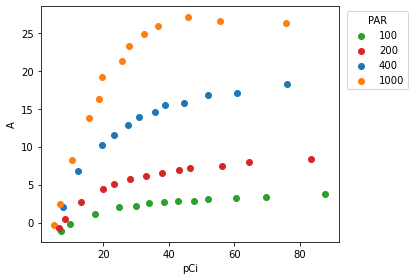

In [4]:
# Plot the raw assimilation vs Ci values seperated by light level
my_df = aci_functions.split_light_curve(aci_functions.read_licor(file))
plt_df = aci_functions.get_plt_df(my_df)
aci_functions.plot_curve(plt_df)

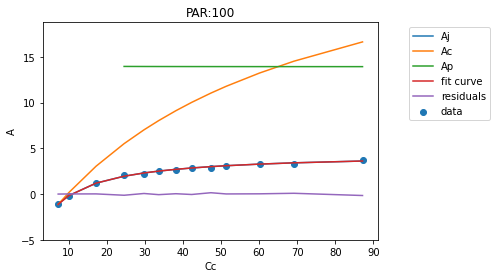

aG: 0.004 @t-leaf, 0.004 @25C 

aS: 0.0 @t-leaf, 0.0 @25C 

Rd: 3.023 @t-leaf, 3.022 @25C 

Vcmax: 34.991 @t-leaf, 35.001 @25C 

j: 29.896 @t-leaf, 29.897 @25C 

TPU: 5.648 @t-leaf, 5.328 @25C 

gm: 7.0 @t-leaf, 6.997 @25C 



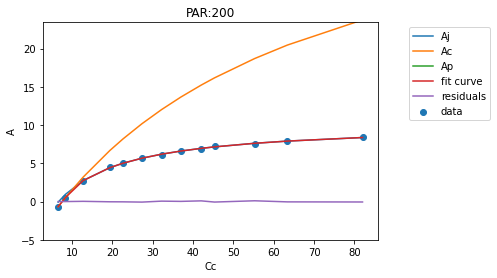

aG: 0.401 @t-leaf, 0.401 @25C 

aS: 0.527 @t-leaf, 0.527 @25C 

Rd: 3.949 @t-leaf, 3.948 @25C 

Vcmax: 49.848 @t-leaf, 49.862 @25C 

j: 56.657 @t-leaf, 56.66 @25C 

TPU: 9.109 @t-leaf, 8.593 @25C 

gm: 7.0 @t-leaf, 6.997 @25C 



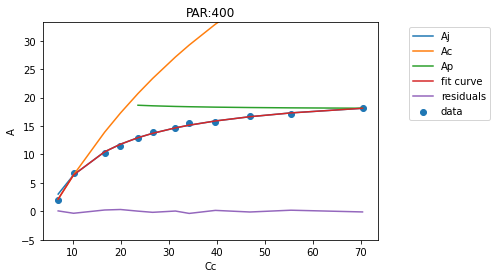

aG: 0.03 @t-leaf, 0.03 @25C 

aS: 0.028 @t-leaf, 0.028 @25C 

Rd: 3.098 @t-leaf, 3.097 @25C 

Vcmax: 100.52 @t-leaf, 100.549 @25C 

j: 98.605 @t-leaf, 98.609 @25C 

TPU: 7.003 @t-leaf, 6.607 @25C 

gm: 3.33 @t-leaf, 3.328 @25C 



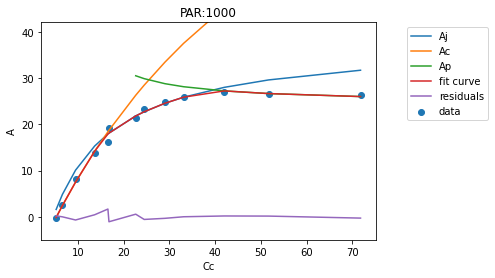

aG: 0.0 @t-leaf, 0.0 @25C 

aS: 0.237 @t-leaf, 0.237 @25C 

Rd: 3.481 @t-leaf, 3.48 @25C 

Vcmax: 131.528 @t-leaf, 131.566 @25C 

j: 165.989 @t-leaf, 165.996 @25C 

TPU: 9.35 @t-leaf, 8.821 @25C 

gm: 7.0 @t-leaf, 6.997 @25C 



In [5]:
# loop through light values and fit A/Ci curve
for light in sorted(set(plt_df["light_label"])):
    
    # get the subset of data for this light
    df_sub = plt_df[plt_df["light_label"] == light]
    df = df_sub.sort_values("pci")
    df.reset_index(inplace=True)
    def resid_func(args):
        return aci_functions.Afunc(df, *args) - df["a"]
    
    # fit A/ci curve
    result = least_squares(resid_func, x0=p0, bounds=bounds )
    popt_A = result.x
    df["cc"] = aci_functions.CcFunc(df, popt_A[6])#df["Pci"] - df['A']/popt_A[6]
    

    # plot raw data, fit curve, and residuals
    plt.figure()
    plt.scatter(df["cc"], df["a"], label='data')
    plt.plot( df['cc'], aci_functions.AjFunc(df,*popt_A), label="Aj")
    plt.plot( df['cc'], aci_functions.AcFunc(df,*popt_A), label="Ac")
    plt.plot( df['cc'], aci_functions.ApFunc(df,*popt_A), label="Ap")
    plt.plot( df['cc'], aci_functions.Afunc(df, *popt_A), label="fit curve")
    plt.plot( df['cc'], resid_func(popt_A), label="residuals")
    plt.legend(bbox_to_anchor=(1.35,1))
    plt.ylim(-5,max(df['a']+15))
    plt.xlabel("Cc")
    plt.ylabel("A")
    plt.title("PAR:{0}".format(light))
    plt.show()
    # print fitted parameters 
    aci_functions.print_param(aci_functions.Afunc, popt_A)